📊 Segment-Wise Evaluation Table:



Segment  Samples  Precision  Recall  F1 Score
0         BalanceFluctuation Risk     7307     0.5481  0.6722    0.6038
1                 YoungLowBalance     3047     0.6005  0.5706    0.5852
2          HighOverdraft HighRisk    14415     0.5861  0.5655    0.5756
3     MultipleProducts LowBalance     7582     0.5322  0.5614    0.5464
4   FrequentComplaints Unresolved    14927     0.5610  0.5389    0.5498
5             StickyButLowDeposit     5970     0.5176  0.5275    0.5225
6         LowLoyalty HighActivity    23787     0.5535  0.4900    0.5198
7       YoungLowIncome LowBalance     2098     0.7410  0.4786    0.5816
8     DepositDependent IncomeDrop    12679     0.5517  0.4739    0.5098
9            YoungAggressiveSaver     2826     0.6402  0.4621    0.5367
10   HighBalance NoIncomeIncrease    10015     0.5523  0.4586    0.5011
11      OlderLowRiskLowEngagement       76     1.0000  0.4000    0.5714

C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\3736753912.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_df, x="Recall", y="Segment", palette="coolwarm")


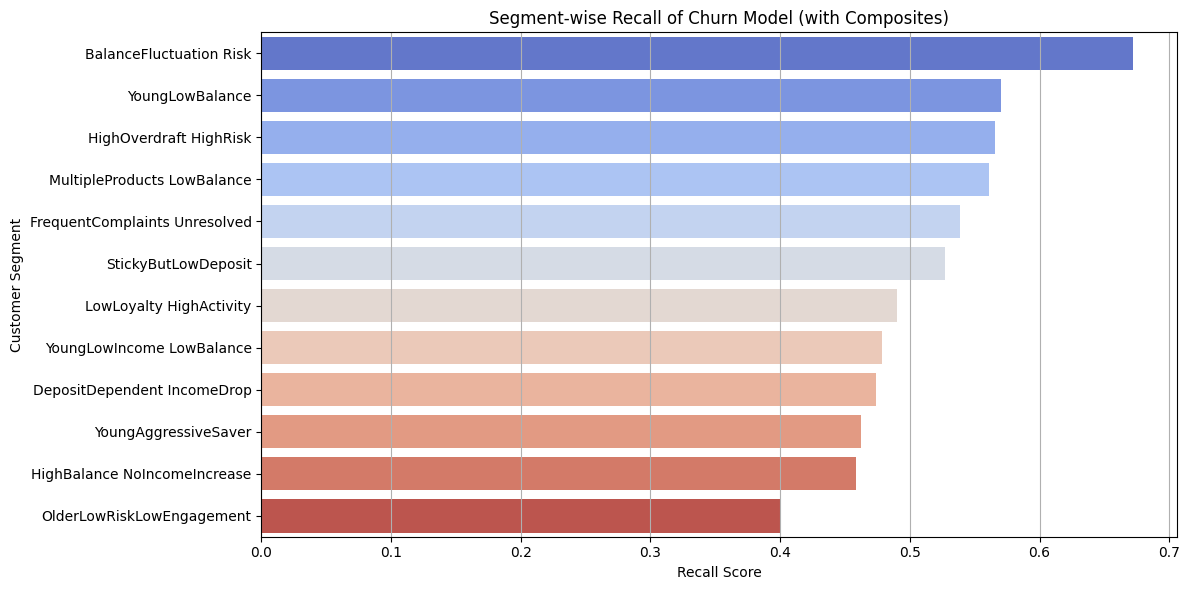

In [3]:
# 📌 Segment-wise Evaluation with Matching Preprocessing
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load data and model
df = pd.read_csv("../data/features_with_composites.csv")
y = pd.read_csv("../data/hidden_churn_labels.csv")["Churn"]
xgb_model = joblib.load("../models/xgb_model_with_composites.pkl")

# ✅ Define feature groups (must match training!)
categorical_features = ['Gender', 'Income_Group', 'Customer_Type', 'Residency_Status', 'Account_Type', 'Credit_Score']
numerical_features = [col for col in df.columns if col not in categorical_features + ["Customer_ID"]]

# ✅ Build the preprocessor exactly like in 03_xgboost_with_composites.ipynb
from sklearn.pipeline import Pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# ✅ Prepare full feature matrix (with encoding)
X = df.drop(columns=["Customer_ID"])
X_processed = preprocessor.fit_transform(X)

# ✅ Predict with model
y_pred_all = xgb_model.predict(X_processed)

# ✅ Segment-wise logic
segment_columns = [col for col in df.columns if col.startswith("Segment_")]
segment_results = []

for segment in segment_columns:
    mask = df[segment] == 1
    if mask.sum() == 0:
        continue

    segment_name = segment.replace("Segment_", "").replace("_", " ")
    segment_y_true = y[mask]
    segment_y_pred = y_pred_all[mask]

    precision = precision_score(segment_y_true, segment_y_pred, zero_division=0)
    recall = recall_score(segment_y_true, segment_y_pred, zero_division=0)
    f1 = f1_score(segment_y_true, segment_y_pred, zero_division=0)

    segment_results.append({
        "Segment": segment_name,
        "Samples": len(segment_y_true),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

# ✅ Create result DataFrame
segment_df = pd.DataFrame(segment_results).sort_values(by="Recall", ascending=False).reset_index(drop=True)
print("📊 Segment-Wise Evaluation Table:\n")
display(segment_df)

# ✅ Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=segment_df, x="Recall", y="Segment", palette="coolwarm")
plt.title("Segment-wise Recall of Churn Model (with Composites)")
plt.xlabel("Recall Score")
plt.ylabel("Customer Segment")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


✔️ Composite columns used for analysis:
['Loyalty_Score', 'Credit_Score_x_Loan_EMI', 'Loyalty_Score_x_Account_Activity', 'Risk_Profile_Score', 'Engagement_Drop_Score', 'RiskAware_Saver_Score', 'Overdraft_Dependency_Score', 'Frustration_Score', 'Exit_Intent_Score', 'Financial_Pressure_Score', 'Passive_Relationship_Score', 'Confidence_Drop_Score', 'Stickiness_Score', 'Product_Confusion_Score', 'RedAlert_Score', 'Undervalued_Customer_Score', 'Churn_Heat_Index']


C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\1731473624.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_composite_df.reset_index(), x="RedAlert_Score", y="Segment", palette="rocket")


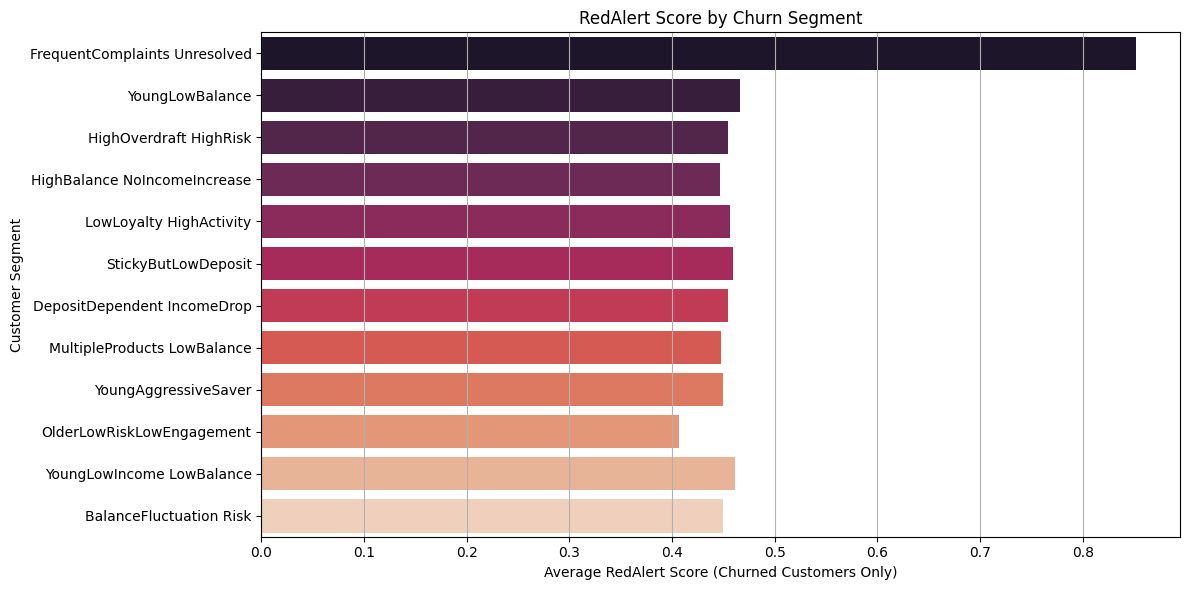

In [6]:
# 📌 Segment-Aligned Composite Score Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load enriched dataset and labels
df = pd.read_csv("../data/features_with_composites.csv")
y = pd.read_csv("../data/hidden_churn_labels.csv")["Churn"]

# ✅ Filter churners only
df["Churn"] = y
df_churned = df[df["Churn"] == 1]

# ✅ Get segment and composite columns
segment_columns = [col for col in df.columns if col.startswith("Segment_")]
all_possible_composites = [col for col in df.columns if "Score" in col or "Index" in col]

# ✅ Keep only numeric composite columns (ignore categorical like Credit_Score)
composite_columns = [col for col in all_possible_composites if pd.api.types.is_numeric_dtype(df[col])]

# ✅ Verify column types
print("✔️ Composite columns used for analysis:")
print(composite_columns)

# ✅ Segment-level composite analysis for churners only
segment_composite_results = []

for segment in segment_columns:
    mask = df_churned[segment] == 1
    if mask.sum() == 0:
        continue

    segment_name = segment.replace("Segment_", "").replace("_", " ")
    avg_scores = df_churned.loc[mask, composite_columns].mean(numeric_only=True)

    result = {"Segment": segment_name}
    result.update(avg_scores.to_dict())
    segment_composite_results.append(result)

# ✅ Create and display final DataFrame
segment_composite_df = pd.DataFrame(segment_composite_results).set_index("Segment").round(3)

# Display in notebook (skip ace_tools if not available)
import matplotlib.pyplot as plt
import seaborn as sns

# Example visualization for top composite signal
plt.figure(figsize=(12, 6))
sns.barplot(data=segment_composite_df.reset_index(), x="RedAlert_Score", y="Segment", palette="rocket")
plt.title("RedAlert Score by Churn Segment")
plt.xlabel("Average RedAlert Score (Churned Customers Only)")
plt.ylabel("Customer Segment")
plt.tight_layout()
plt.grid(True, axis="x")
plt.show()


C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_composite_df.reset_index(), x=score, y="Segment", palette="rocket")
C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\pullu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


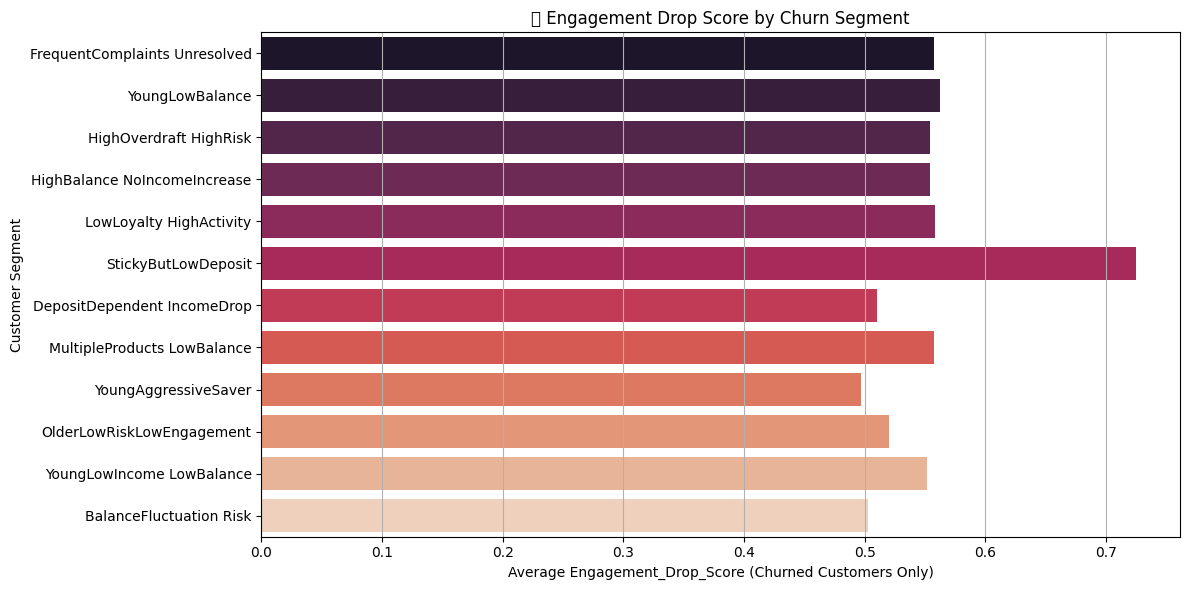

C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_composite_df.reset_index(), x=score, y="Segment", palette="rocket")
C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\pullu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


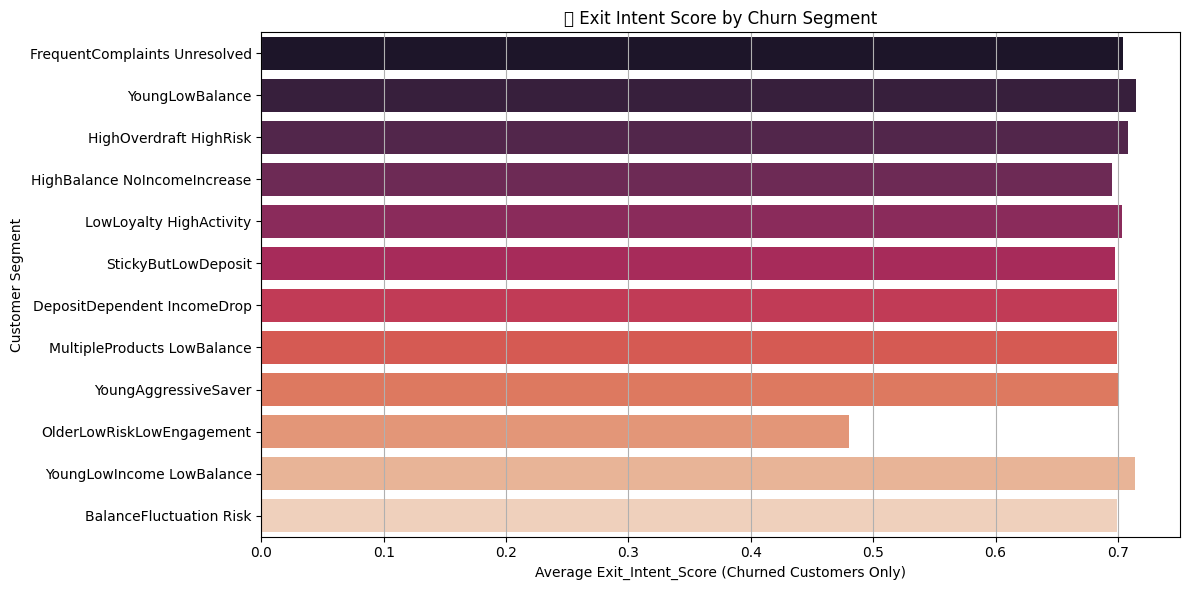

C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_composite_df.reset_index(), x=score, y="Segment", palette="rocket")
C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\pullu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


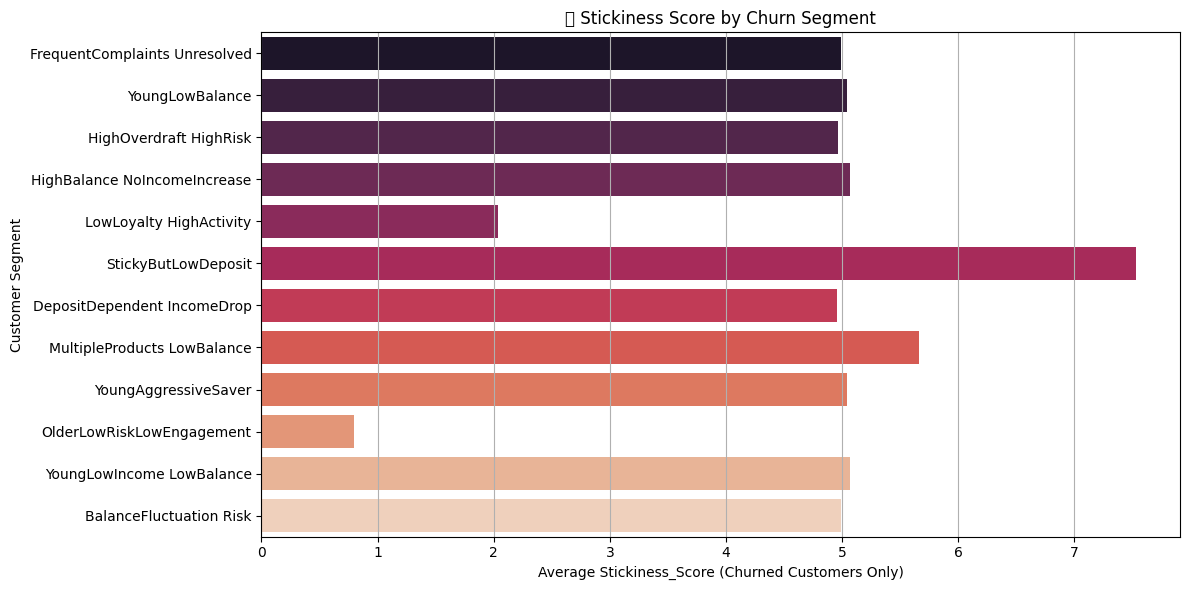

C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_composite_df.reset_index(), x=score, y="Segment", palette="rocket")
C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\pullu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


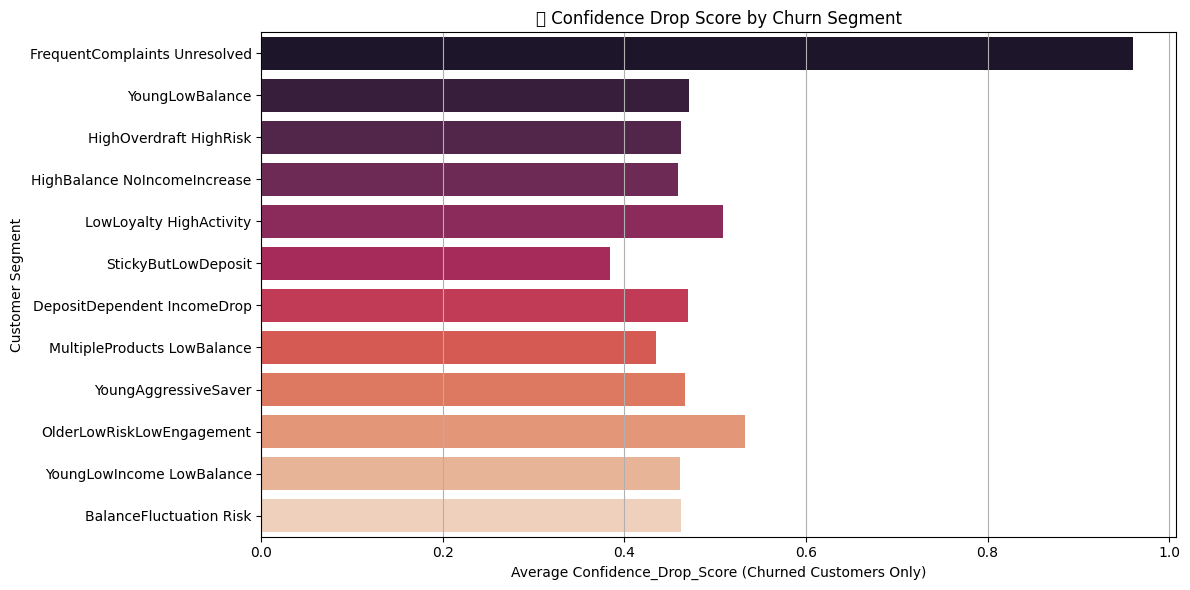

C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_composite_df.reset_index(), x=score, y="Segment", palette="rocket")
C:\Users\pullu\AppData\Local\Temp\ipykernel_52320\340979835.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\pullu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


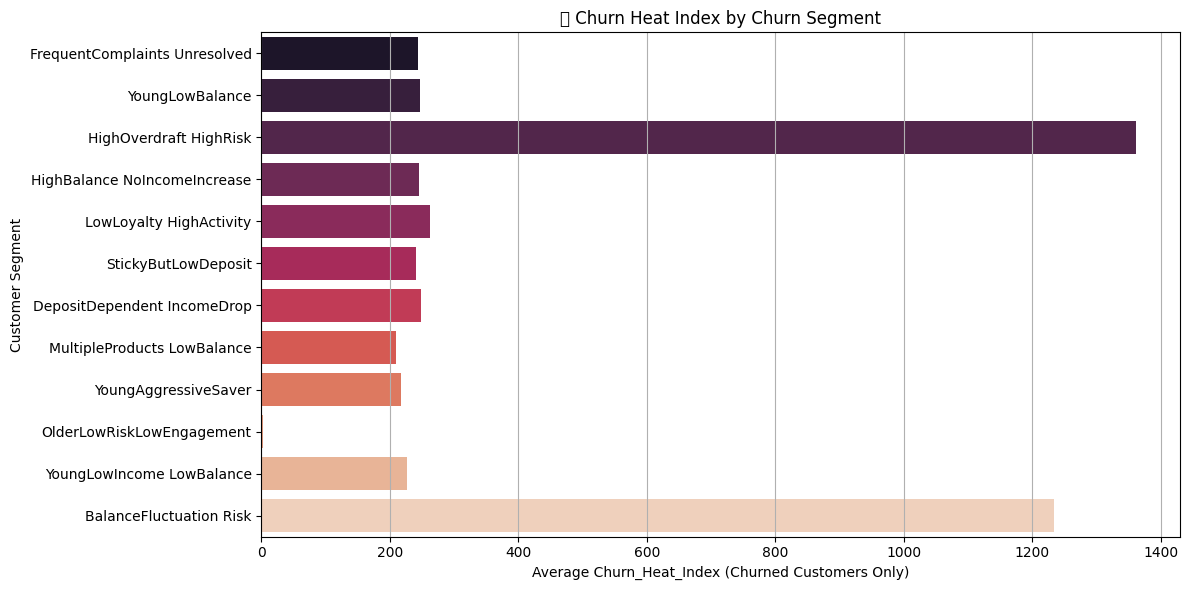

In [7]:
composite_indicators = [
    "Engagement_Drop_Score",
    "Exit_Intent_Score",
    "Stickiness_Score",
    "Confidence_Drop_Score",
    "Churn_Heat_Index"
]

for score in composite_indicators:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=segment_composite_df.reset_index(), x=score, y="Segment", palette="rocket")
    plt.title(f"🔍 {score.replace('_', ' ')} by Churn Segment")
    plt.xlabel(f"Average {score} (Churned Customers Only)")
    plt.ylabel("Customer Segment")
    plt.tight_layout()
    plt.grid(True, axis="x")
    plt.show()
